In [454]:
import random
import numpy as np
import matplotlib.pyplot as plt
import cvxopt
import pickle

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'


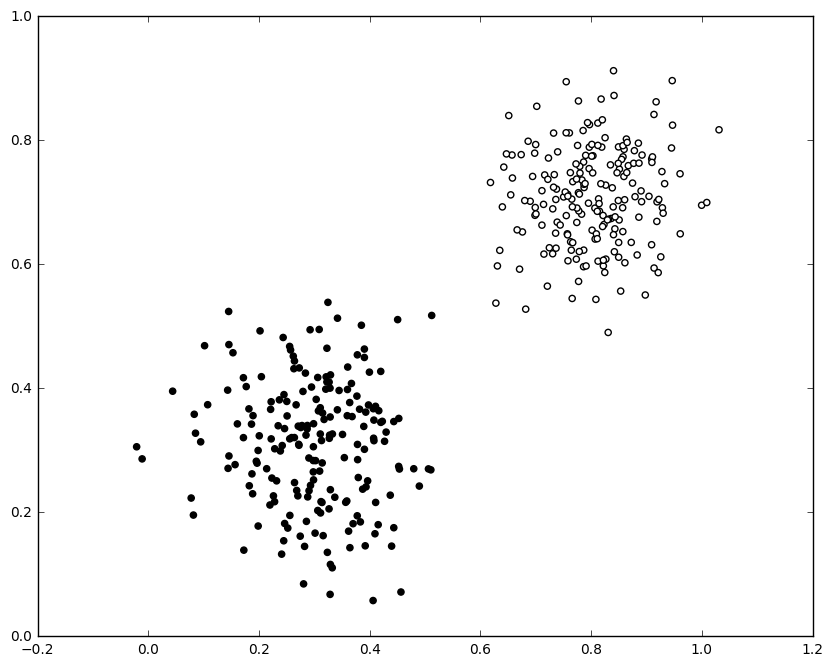

In [500]:
K = 2
N = 200

X = np.vstack((np.random.normal(loc=[0.3, 0.3], scale = 0.1, size = (N, 2)),
               np.random.normal(loc=[0.8, 0.7], scale = 0.08, size = (N, 2))))
y = np.hstack((-1 * np.ones(N), np.ones(N)))

train_test_split = np.array(random.sample(range(N * 2), N))

X_train = X[train_test_split, :]
y_train = y[train_test_split]
    
X_test = X[-train_test_split, :]
y_test = y[-train_test_split]

plt.scatter(X[:, 0], X[:, 1], c = y)

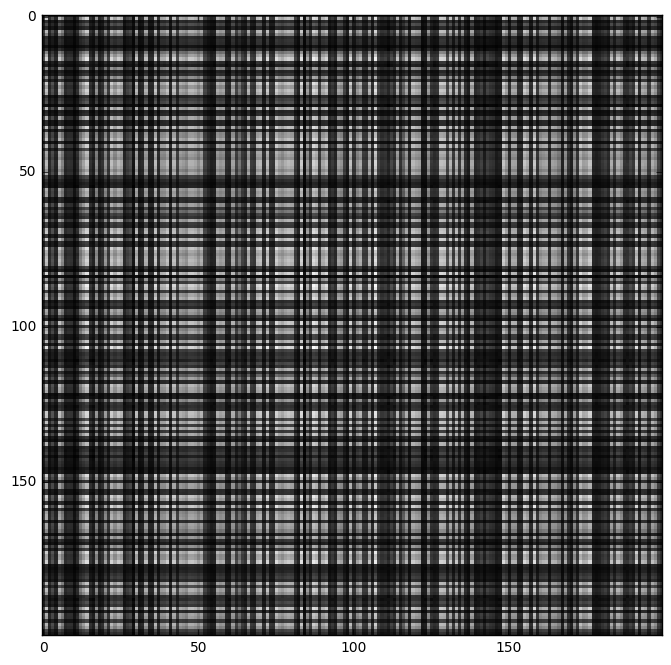

In [501]:
svm_lambda = 0.05
svm_kernel = lambda X, Y: (np.dot(X, Y.T) + 1.0) ** 2

plt.imshow(svm_kernel(X_train, X_train))

     pcost       dcost       gap    pres   dres
 0: -1.4329e+01 -4.6925e+01  6e+02  2e+01  2e+00
 1: -1.7477e+01 -3.8087e+01  2e+02  8e+00  7e-01
 2: -1.1817e+02 -1.1272e+02  2e+02  7e+00  6e-01
 3: -1.0181e+02 -8.7545e+01  6e+01  2e+00  1e-01
 4: -7.5258e+01 -7.4260e+01  7e+00  2e-01  1e-02
 5: -7.2499e+01 -7.2492e+01  2e-01  4e-03  3e-04
 6: -7.2451e+01 -7.2451e+01  2e-03  4e-05  3e-06
 7: -7.2451e+01 -7.2451e+01  2e-05  4e-07  3e-08
 8: -7.2451e+01 -7.2451e+01  2e-07  4e-09  3e-10
Optimal solution found.
beta0 = [ 5.07079646]


(array([   2.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,  198.]),
 array([ -6.13139804e+01,  -5.51775823e+01,  -4.90411843e+01,
         -4.29047863e+01,  -3.67683882e+01,  -3.06319902e+01,
         -2.44955922e+01,  -1.83591941e+01,  -1.22227961e+01,
         -6.08639804e+00,   5.00000001e-02]),
 <a list of 10 Patch objects>)

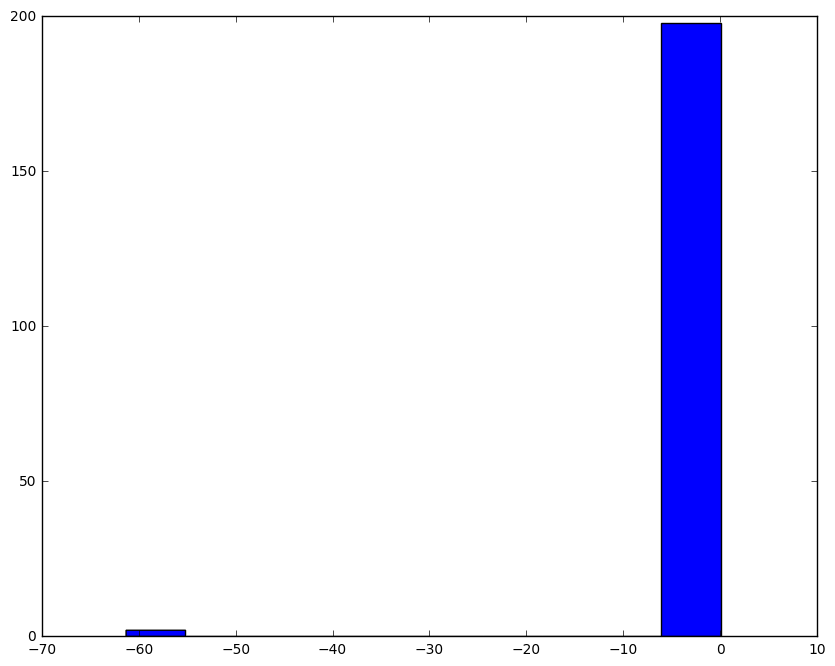

In [513]:
# The Elements of Statistical Learning: Data Mining, Inference, and Prediction, 2nd ed
# Trevor Hastie, Robert Tibshirani, Jerome Friedman
# https://statweb.stanford.edu/~tibs/ElemStatLearn/
# pp. 420, 423

# L = sum(alpha) + 1/2 * sum_i(sum_j(alpha_i * alpha_j * y_i * y_j * kernel(x_i, x_j)))
# subject to sum(alpha) = 0
#            alpha < 1/(2 * N * svn_lambda)

# http://cvxopt.org/userguide/coneprog.html#quadratic-programming
# minimize 1/2 * x.T * P * x + q.T * x
# subject to G * x < h
#            A * x = b

def svm_train(X, y):   
    P = cvxopt.matrix(svm_kernel(X_train, X_train) * np.outer(y, y))
    q = cvxopt.matrix(np.ones(N))
    G = cvxopt.matrix(np.eye(N))
    h = cvxopt.matrix(np.ones(N) / (2. * N * svm_lambda))
    A = cvxopt.matrix(y_train, (1, N))
    b = cvxopt.matrix(0.0)

    solution = cvxopt.solvers.qp(P, q, G, h, A, b)
    
    alpha = np.array(solution["x"]).reshape(-1)
    
    any_i = np.argmax(np.abs(alpha))
    beta0 = y_train[any_i] - np.sum(alpha * y_train * svm_matrix(X_train, X_train[any_i, None]).T, axis = 1)
    
    return (alpha, beta0)

# TODO: why alphas are negative, and why classes are swapped after predict

(alpha, beta0) = svm_train(X_train, y_train)

print("beta0 =", beta0)
plt.hist(alpha)

(array([  5.,  24.,  34.,  21.,  10.,   1.,  18.,  52.,  26.,   9.]),
 array([-15.71372491, -14.06456543, -12.41540594, -10.76624646,
         -9.11708698,  -7.4679275 ,  -5.81876802,  -4.16960854,
         -2.52044906,  -0.87128958,   0.7778699 ]),
 <a list of 10 Patch objects>)

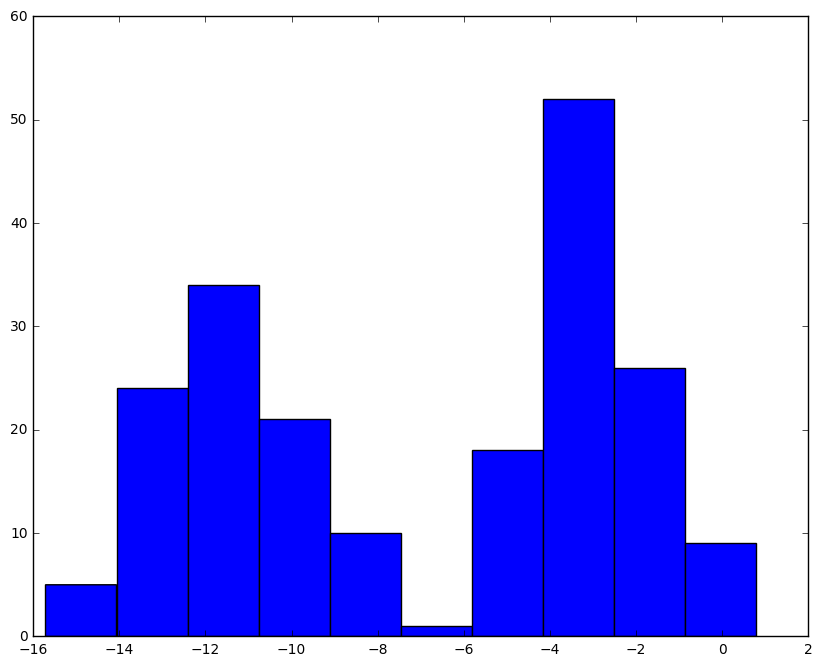

In [514]:
plt.hist(np.sum(alpha * y_train * svm_kernel(X_train, X_train).T, axis = 1))

In [515]:
def svm_predict(X):  
    return np.sign(np.sum(alpha * y_train * svm_matrix(X_train, X).T, axis = 1) + beta0)

print("accuracy on training set =", (svm_predict(X_train) == y_train).mean())
print("accuracy on test set =", (svm_predict(X_test) == y_test).mean())


accuracy on training set = 0.02
accuracy on test set = 0.03


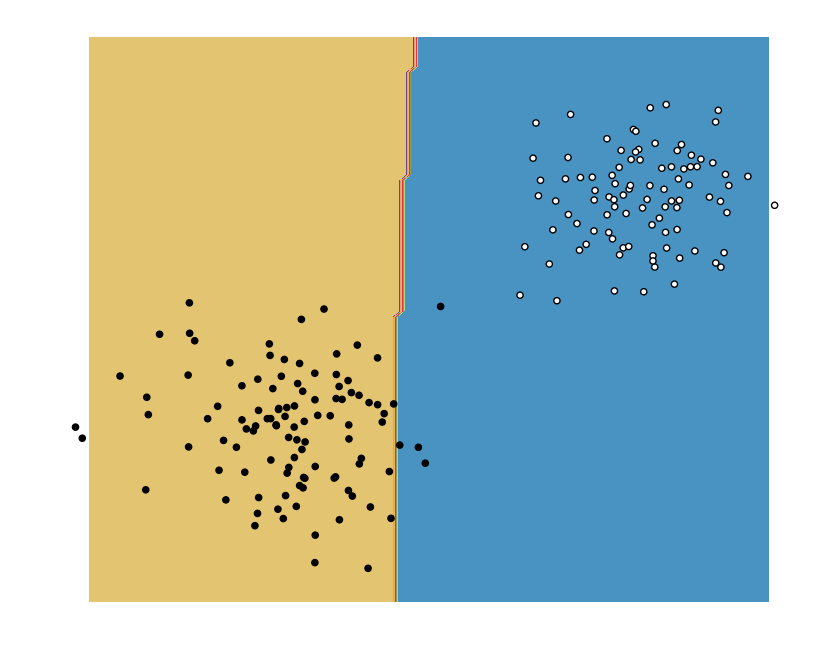

In [516]:
xx, yy = np.meshgrid(np.arange(0, 1, 0.01), np.arange(0, 1, 0.01))
X_boundary = np.c_[xx.ravel(), yy.ravel()]
y_boundary = svm_predict(X_boundary)

plt.contourf(xx, yy, y_boundary.reshape(xx.shape), cmap=plt.cm.Paired)
plt.axis('off')
plt.scatter(X_train[:, 0], X_train[:, 1], c = y_train)